# Decision Tree Model


### Importing Libraries

In [7]:
# 1) Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from imblearn.over_sampling import SMOTE

### Load Dataset

In [3]:
# 2) Load Data
df = pd.read_csv("student_performance/StudentPerformanceFactorsAdjusted.csv")

### Data Preprocessing

In [4]:
# 3) Encode Categorical Values
label_encoders = {}
categorical_columns = df.select_dtypes(include='object').columns

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 3) Define Features and target
X = df.drop('Exam_Score', axis=1)
y = df['Exam_Score']

# Aggregate Scores into Ranges
def aggregate_classes(score):
    if score >= 55 and score <= 60:
        return "55-60"
    elif score >= 61 and score <= 65:
        return "61-65"
    elif score >= 66 and score <= 70:
        return "66-70"
    elif score >= 71 and score <= 75:
        return "71-75"
    elif score >= 76 and score <= 80:
        return "76-80"
    else:
        return "81+"
    
# Apply Grouping to Target Variable
y_aggregated = y.map(aggregate_classes)

# 4) Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4) Identify Numeric and Categorical Columns
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# 5) Create Preprocessing Pipelines
# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# 6) Combine Preprocessing Steps
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 7) Split Data
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8) Create the Full Pipeline
# Create and train the full pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# 9) Hyperparameter Tuning
# Define hyperparameter grid
param_grid = {
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    full_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", -grid_search.best_score_)

# Display the best parameters as statistics in order of most important to least important
best_params = grid_search.best_params_
sorted_params = sorted(best_params.items(), key=lambda x: x[1], reverse=True)
for param, value in sorted_params:
    print(f"{param}: {value}")

# Update pipeline with best parameters
full_pipeline = grid_search.best_estimator_

# 10) Train the Model
# Fit the pipeline
full_pipeline.fit(X_train, y_train)

#11) Evaluate the Model
# Make predictions
y_pred = full_pipeline.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error: ", rmse)
print("R2 Score:", r2)

Best parameters: {'regressor__max_depth': 5, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 2}
Best cross-validation score: 7.919373044785777
regressor__max_depth: 5
regressor__min_samples_leaf: 4
regressor__min_samples_split: 2
Mean Squared Error: 6.286720080351721
Root Mean Squared Error:  2.507333260727764
R2 Score: 0.5552396287790213


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### Compare Datasets

In [5]:
# Assuming 'default_pipeline' is the pipeline without hyperparameter tuning
default_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Fit the default pipeline
default_pipeline.fit(X_train, y_train)

# Make predictions with the default pipeline
y_pred_default = default_pipeline.predict(X_test)

# Calculate metrics for the default pipeline
mse_default = mean_squared_error(y_test, y_pred_default)
rmse_default = np.sqrt(mse_default)
r2_default = r2_score(y_test, y_pred_default)

print("Default Pipeline Metrics:")
print("Mean Squared Error:", mse_default)
print("Root Mean Squared Error: ", rmse_default)
print("R2 Score:", r2_default)

# Compare the metrics
print("\nComparison with Tuned Pipeline:")
print("Tuned MSE vs Default MSE:", mse, "vs", mse_default, "(",(mse-mse_default)/mse *100,")")
print("Tuned RMSE vs Default MSE:", rmse, "vs", rmse_default, "(",(rmse-rmse_default)/rmse *100,")")
print("Tuned R2 vs Default R2:", r2, "vs", r2_default, "(",(r2-r2_default)/r2 *100,")")

Default Pipeline Metrics:
Mean Squared Error: 14.193645990922844
Root Mean Squared Error:  3.767445552482855
R2 Score: -0.0041438427697293445

Comparison with Tuned Pipeline:
Tuned MSE vs Default MSE: 6.286720080351721 vs 14.193645990922844 ( -125.77187801446948 )
Tuned RMSE vs Default MSE: 2.507333260727764 vs 3.767445552482855 ( -50.2570723841209 )
Tuned R2 vs Default R2: 0.5552396287790213 vs -0.0041438427697293445 ( 100.74631610478555 )


### Data Visualizations

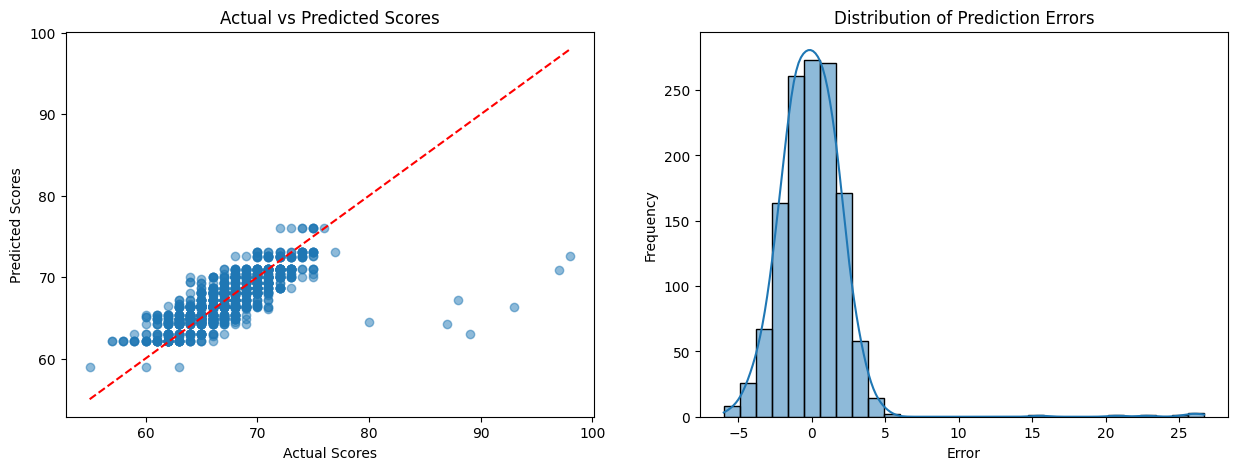

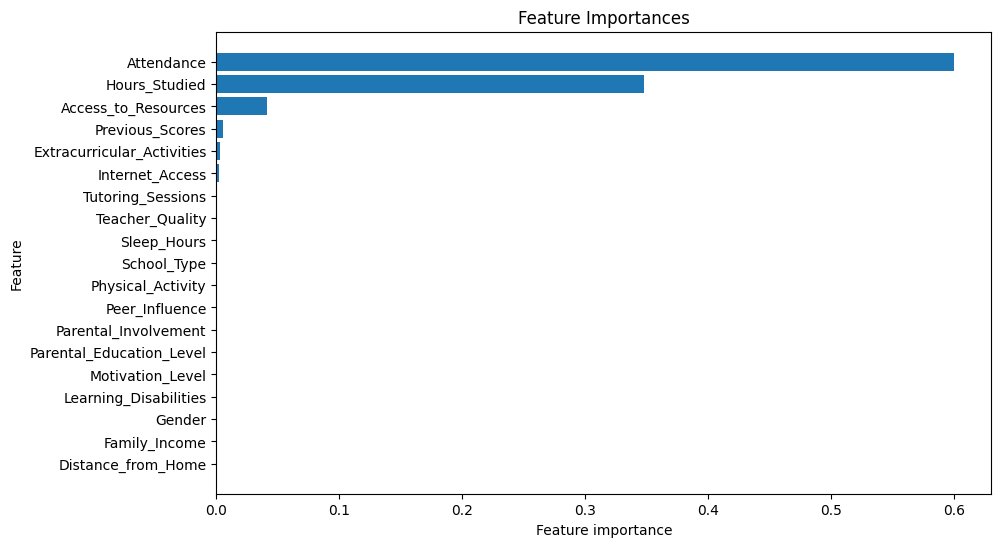

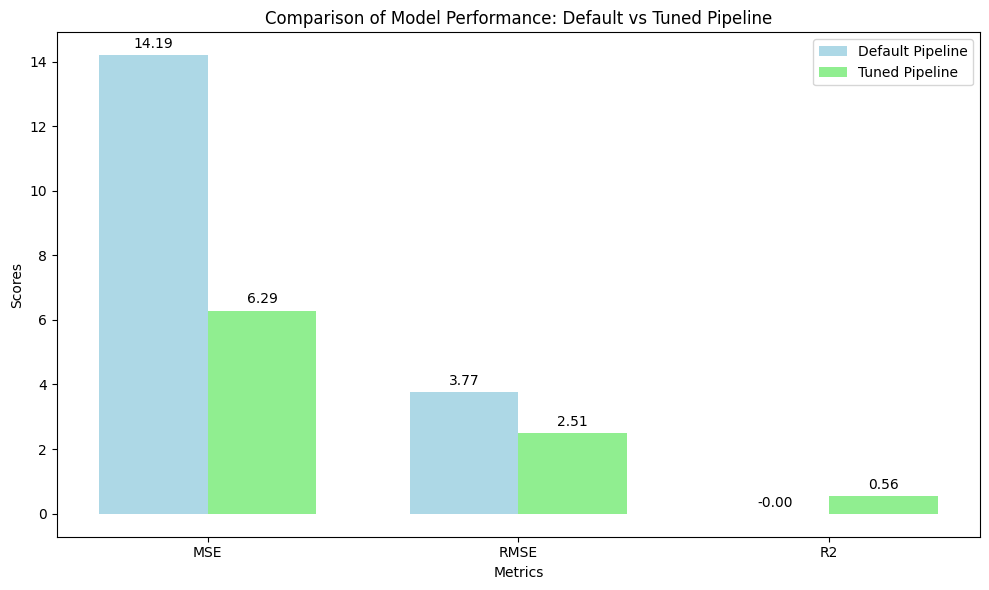

In [6]:
# 1) Scatter Plot of Predictions vs Actuals
plt.figure(figsize=(15, 5))

# Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Scores')

plt.subplot(1, 2, 2)
errors = y_test - y_pred
sns.histplot(errors, kde=True, bins=30)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')

# 2) Feature Importance
# Assuming 'tuned_model' is the tuned model with feature importance
feature_importances = grid_search.best_estimator_.named_steps['regressor'].feature_importances_
feature_names = X_train.columns

# Sort the features by their importance
feature_importances, feature_names = zip(*sorted(zip(feature_importances, feature_names)))

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names)), feature_importances, align='center')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

# Data Visualization for Model Comparison-----------------------------------
import matplotlib.pyplot as plt

# Prepare data for comparison
metrics = ['MSE', 'RMSE', 'R2']
default_metrics = [mse_default, rmse_default, r2_default]
tuned_metrics = [mse, rmse, r2]

# Create a bar chart
x = range(len(metrics))  # x locations for the groups
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bars
bars1 = ax.bar(x, default_metrics, width, label='Default Pipeline', color='lightblue')
bars2 = ax.bar([p + width for p in x], tuned_metrics, width, label='Tuned Pipeline', color='lightgreen')

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance: Default vs Tuned Pipeline')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(metrics)
ax.legend()

# Adding value labels on top of the bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',  # Format the height to 2 decimal places
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()